# Classification Modeling

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

import classifiers as clf

### Load Species Data

In [2]:
species = pd.read_pickle("../Data/species.pkl")
species.head()

,Scientific Name,Common Name,Federal Listing Status,Group_Amphibians,Group_Annelid Worms,Group_Arachnids,Group_Birds,Group_Clams,Group_Conifers and Cycads,Group_Corals,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,Accipiter gentilis,Northern goshawk,Not Listed,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acipenser fulvescens,Lake sturgeon,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acipenser oxyrinchus (=oxyrhynchus) desotoi,Atlantic sturgeon (Gulf subspecies),Threatened,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Agarodes alabamensis,[Unnamed] caddisfly,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agrimonia incisa,Incised groovebur,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Set Target and Feature Variables

In [3]:
# Create target and feature variables
y = species['Federal Listing Status']
X = species.drop(['Federal Listing Status', 'Scientific Name', 'Common Name'], axis = 1)

### Create Training and Test Sets

In [4]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# federal listing status
print('Training Data: ' + str(y_train.count()))
print('Endangered:    ' + str((y_train == 'Endangered').sum() / y_train.count()))
print('Not Listed:    ' + str((y_train == 'Not Listed').sum() / y_train.count()))
print('Threatened:    ' + str((y_train == 'Threatened').sum() / y_train.count()))

# federal listing status
print('Test Data:     ' + str(y_test.count()))
print('Endangered:    ' + str((y_test == 'Endangered').sum() / y_test.count()))
print('Not Listed:    ' + str((y_test == 'Not Listed').sum() / y_test.count()))
print('Threatened:    ' + str((y_test == 'Threatened').sum() / y_test.count()))

Training Data: 9389
Endangered:    0.16082649909468527
Not Listed:    0.7698370433485994
Threatened:    0.0693364575567153
Test Data:     2348
Endangered:    0.16567291311754684
Not Listed:    0.7717206132879046
Threatened:    0.06260647359454855


### Data Scaling

### Baseline Classification Models

In [5]:
classifiers = []

classifiers.append({'Model': 'Dummy',
                    'Classifier': DummyClassifier(strategy='most_frequent')})

classifiers.append({'Model': 'Logistic Regression',
                    'Classifier': LogisticRegression(C=1e12,
                                                     solver='newton-cg',
                                                     multi_class='ovr',
                                                     penalty='l2')})

classifiers.append({'Model': 'K Nearest Neighbors',
                    'Classifier': KNeighborsClassifier()})

classifiers.append({'Model': 'Decision Tree',
                    'Classifier': DecisionTreeClassifier()})

classifiers, metrics = clf.classify(classifiers, X_train, X_test, y_train, y_test)

baseline = pd.DataFrame(metrics, columns=['Model',
                                          'Split',
                                          'Accuracy',
                                          'Precision',
                                          'Recall',
                                          'F1 Score'])
baseline['Configuration'] = 'Baseline'

models = baseline.copy()
baseline.pivot(index='Model', columns='Split')

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy           Precision              Recall  \
Split                    Test     Train      Test     Train      Test   
Model                                                                   
Decision Tree        0.804514  0.839174  0.776507  0.827635  0.804514   
Dummy                0.771721  0.769837  0.595553  0.592649  0.771721   
K Nearest Neighbors  0.784923  0.807860  0.779357  0.810283  0.784923   
Logistic Regression  0.807070  0.808393  0.782146  0.777719  0.807070   

                               F1 Score           Configuration            
Split                   Train      Test     Train          Test     Train  
Model                                                                      
Decision Tree        0.839174  0.779910  0.817584      Baseline  Baseline  
Dummy                0.769837  0.672287  0.669722      Baseline  Baseline  
K Nearest Neighbors  0.807860  0.776205  0.798982      Baseline  Baseline  
Logistic Regression  0.808393  0.762979  0.763000      Baseline  Baseline

### Handling Class Imbalance with SMOTE Oversampling

9389
Endangered: 0.16082649909468527
Not Listed: 0.7698370433485994
Threatened: 0.0693364575567153


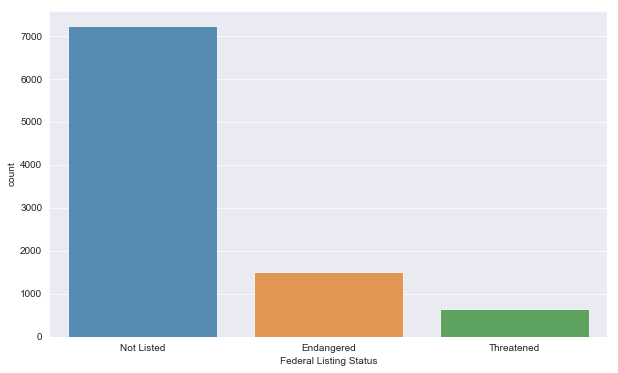

In [6]:
# federal listing status
print(y_train.count())
print('Endangered: ' + str((y_train == 'Endangered').sum() / y_train.count()))
print('Not Listed: ' + str((y_train == 'Not Listed').sum() / y_train.count()))
print('Threatened: ' + str((y_train == 'Threatened').sum() / y_train.count()))

# plot class imbalance
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_train, alpha=0.8)

In [7]:
keys = list(y_train.unique())
values = np.ones((3), dtype=int) * (y_train == 'Not Listed').sum()
sample_ratio = dict(zip(keys, values))
sample_ratio

{'Not Listed': 7228, 'Endangered': 7228, 'Threatened': 7228}

21684
Endangered: 0.3333333333333333
Not Listed: 0.3333333333333333
Threatened: 0.3333333333333333


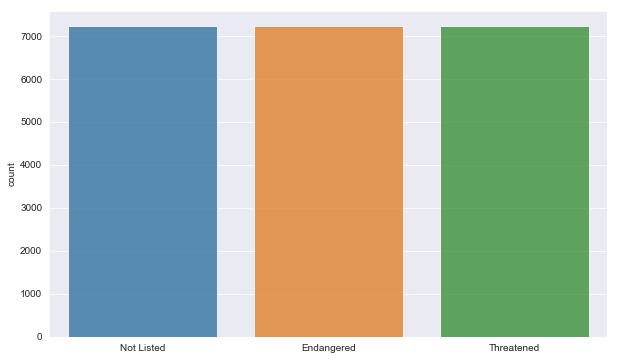

In [8]:
species['Federal Listing Status'].unique()

smote = SMOTE(ratio=sample_ratio)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

# federal listing status
print(len(y_train_smote))
print('Endangered: ' + str((y_train_smote == 'Endangered').sum() / len(y_train_smote)))
print('Not Listed: ' + str((y_train_smote == 'Not Listed').sum() / len(y_train_smote)))
print('Threatened: ' + str((y_train_smote == 'Threatened').sum() / len(y_train_smote)))

# plot class imbalance
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_train_smote, alpha=0.8)

### Balanced Classification Models

In [9]:
classifiers = []

classifiers.append({'Model': 'Dummy',
                    'Classifier': DummyClassifier(strategy='most_frequent')})

classifiers.append({'Model': 'Logistic Regression',
                    'Classifier': LogisticRegression(C=1e12,
                                                     solver='newton-cg',
                                                     multi_class='ovr',
                                                     penalty='l2')})

classifiers.append({'Model': 'K Nearest Neighbors',
                    'Classifier': KNeighborsClassifier()})

classifiers.append({'Model': 'Decision Tree',
                    'Classifier': DecisionTreeClassifier()})

classifiers, metrics = clf.classify(classifiers, X_train_smote, X_test, y_train_smote, y_test)

balanced = pd.DataFrame(metrics, columns=['Model',
                                          'Split',
                                          'Accuracy',
                                          'Precision',
                                          'Recall',
                                          'F1 Score'])

balanced['Configuration'] = 'Class Balance'
models = models.append(balanced, ignore_index=True)
balanced.pivot(index='Model', columns='Split')

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy           Precision              Recall  \
Split                    Test     Train      Test     Train      Test   
Model                                                                   
Decision Tree        0.722743  0.799760  0.770631  0.806739  0.722743   
Dummy                0.165673  0.333333  0.027448  0.111111  0.165673   
K Nearest Neighbors  0.783646  0.704575  0.778576  0.723905  0.783646   
Logistic Regression  0.756814  0.662608  0.765356  0.661892  0.756814   

                               F1 Score            Configuration  \
Split                   Train      Test     Train           Test   
Model                                                              
Decision Tree        0.799760  0.740262  0.800040  Class Balance   
Dummy                0.333333  0.047093  0.166667  Class Balance   
K Nearest Neighbors  0.704575  0.777208  0.698443  Class Balance   
Logistic Regression  0.662608  0.760759  0.656531  Class Balance   

                                    
Split                        Train  
Model                               
Decision Tree        Class Balance  
Dummy                Class Balance  
K Nearest Neighbors  Class Balance  
Logistic Regression  Class Balance